In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

########################################################################
# INPUTS
########################################################################

#D0, u0, nloop, xmix, max_omega, T, tol  = np.loadtxt('input.bin')
D0, u0, nloop, xmix, max_omega, T, tol  = 1.0, 2.0, 40, 0.7, 4.0, 0.1, 1e-6

try:

    DOS = np.loadtxt('DOS.txt')

except:

    energies = np.linspace(-D0, D0, 1000)
    DOS = 2*np.sqrt(1-(energies/D0)**2)/(np.pi * D0)



########################################################################
# DMFT ROUTINES
########################################################################

def DMFT_iteration_first_half(u0,S_imp,Energies,Momega,tau,T):
    N_tau = len(tau)
    G_loc = Dyson_Green(S_imp, energies, DOS, Momega)
    G_0 = G_loc/(1+G_loc*S_imp)
    G_0_tau = Inv_Matsubara_Fourier_div (G_0,T,tau,Momega)
    new_S_imp = Self_Energy_fromG(G_0_tau,u0,tau,Momega)
    return G_loc, G_0, G_0_tau, new_S_imp

def Self_Energy_fromG (G,U,tau,omega):
    Ntau = len(tau)
    dtau = tau[1] - tau[0]
    esp = np.exp(1.0j*np.tensordot(tau,omega,0))
    integrand = G*G*G
    return U*U*dtau*np.matmul(integrand,esp)
    
    
def Dyson_Green (Self_Energy, Energy, Density_Energy, omega):
    N_freqs = len(omega)
    epsrep = Energy.reshape((1,-1)).repeat(N_freqs,0)
    desrep = Density_Energy.reshape((1,-1)).repeat(N_freqs,0)
    if len(epsrep) == len(desrep):
        N_e = epsrep.shape[1]
        N_states = desrep.sum()
        summand =omega.reshape((-1,1)).repeat(N_e,1) - epsrep - Self_Energy.reshape((-1,1)).repeat(N_e,1)
        return np.sum(desrep/summand, axis=1)/(N_states)


# Dyson equation

def solve_dyson(G_0, sigma):
    
    """
    Solves the Dyson equation given the impurity self-energy and a (1) non-interacting /
    (2) local Green's function. 
    
    In the first case, yields the impurity Green's function. In the second case, yields
    the non interacting Green's function.
    
    Input:
        G_0:   (1) Non-interacting Green's function in Matsubara axis
               (2) Local Green's function in Matsubara axis
             
        Sigma: The impurity self-energy
        
    Output:
        G_loc: (1) Impurity Green's function in Matsubara axis
               (2) Non-interacting Green's function in Matsubara axis
    """
    
    inverse_G0 = 1/G_0
    G_loc = 1/(inverse_G0 + sigma)
    
    return G_loc


# Self consistent test
    

def convergence_test(G_imp, G_loc, delta):
    
    """
    Given the newly computed impurity Green's function and the old local Green's
    function, performs the convergence test.
    
    Returns True if convergence has been reached with precision delta. Returns 
    False otherwise.
    
    Input:
        G_imp: New impurity Green's function in Matsubara axis
        G_loc: Old local Green's function in Matsubara axis
        delta: Precision level of the DMFT loop
        
    Output:
        bool: True if convergence has been achieved; false otherwise
    """

    difference = np.absolute(G_imp - G_loc)**2
    D = np.sqrt(np.sum(difference))
    
    return bool(np.where(D < delta, True, False))


# Pade approximation for analytical continuation

def real_axis_gf(G_loc, Momega, Romega, delta):
    
    '''
    Given the local Green's function in the Matsubara axis, computes the analytical
    continuation to the real axis with the Maximum Entropy method.
    
    Input:
        G_loc:  Local Green's function in Matsubara axis
        Momega: Matsubara axis grid
        Romega: Real frequency axis grid
        delta:  Precision level of the DMFT loop
        
    Output:
        G_loc_real: Local Green's function in real frequency axis
    '''
    sys.path.insert(0,'Functions/')
    import continuation as cont
    
    G_loc_real_double = np.zeros((Romega.shape[0],2))
    1/tau
    err = np.ones_like(Romega)*delta
    model = np.ones_like(Romega)
    model /= np.trapz(model, Romega)
    
    probl = cont.AnalyticContinuationProblem(im_axis=Momega, re_axis=Romega,
                                             im_data=G_loc, kernel_mode='freq_fermionic')
    
    sol, _ = probl.solve(method='maxent_svd', alpha_determination='chi2kink', optimizer='newton',
                         model=model, stdev=err, interactive=True, alpha_start=1e12, alpha_end=1e-2,
                         preblur=True, blur_width=0.5)
    
    G_loc_real_double[:,0] = sol.backtransform.real
    G_loc_real_double[:,1] = sol.backtransform.imag
    
    G_loc_real = G_loc_real_double[:,0] + 1j*G_loc_real_double[:,1]
    
    return G_loc_real
    
    

# Spectral function

def compute_spectral(G_loc_real):
    
    '''
    Takes the Green's function in real freauency axis and computes the spectral
    function.
    
    Input:
        G_loc_real: Local Green's function in real frequency axis
        
    Output:
        A_real: Spectral function in real frequency axis
        
    '''
    
    A_real = - G_loc_real.imag / np.pi
    
    return A_real


In [20]:
########################################################################
# INITIALIZE FUNCTIONS
########################################################################

Momega = (2*np.arange(500) + 1)*np.pi*T
Romega = Momega
tau = np.linspace(0, 1/T, 1000)
S_imp = np.zeros((len(Momega)))

In [22]:
norb = 1
nw = 500
nw_out = 1000
emin = -10.0
emax = 10.0
inf = open("g_loc.dat",'r')

####################################
####################################
de = (emax-emin)/nw_out
delta = 0.000000001

gf = np.zeros((norb,nw),dtype=complex)
wn = np.zeros((nw))
for n in range(nw):
	data = [float(x) for x in inf.readline().split()]
	wn[n] = data[0]
	for m in range(norb):
		gf[m,n] = data[1 + 2*m] + data[1 + 2*m+1]*1.0j
inf.close()

# pade
pmatrix = np.zeros((norb,nw,nw),dtype=complex)
for m1 in range(norb):
	for n in range(nw):
		pmatrix[m1,0,n] = gf[m1,n]

	for m in range(1,nw):
		for n in range(1,m+1):
			if ( abs(pmatrix[m1,n-1,m]) < delta ):
				continue
			pmatrix[m1,n,m] = ( pmatrix[m1,n-1,n-1] - pmatrix[m1,n-1,m] ) / ( pmatrix[m1,n-1,m]*1.0j*( wn[m]-wn[n-1] ) )


outf = open('pade.dat','w')
for nn in range(nw_out):
	w = emin + nn*de
	outf.write(str(w) + '\t')

	for m1 in range(norb):

		# find good n
		nstart = 0
		for m in range(nw):
			if ( abs(pmatrix[m1,m,m])<delta ):
				break
			nstart += 1
		nstart = min(nstart,nw-1)
		nstart = nw-1

		val = 1.0 + pmatrix[m1,nstart,nstart]*( w - 1.0j*wn[nstart-1] )
		for m in range(nstart-1,0,-1):
			val = 1.0 + pmatrix[m1,m,m]*( w - 1.0j*wn[m-1] )/val
		val = pmatrix[m1,0,0]/val


		outf.write(str(val.real) + '\t' + str(val.imag) + '\t')

	outf.write( '\n')
outf.close()


FileNotFoundError: [Errno 2] No such file or directory: 'g_loc.dat'

In [21]:
########################################################################
# DMFT LOOP
########################################################################


for k in range(nloop):

    G_loc, G_0, G_0_tau, new_S_imp = DMFT_iteration_first_half(u0,S_imp, DOS, Momega, tau, T)
    G_imp = solve_dyson(G_0, new_S_imp)
    
    if convergence_test(G_imp, G_loc,tol):
        print('Convergence has been reached, iteration '+str(k))
        break
    else:
        S_imp = xmix * new_S_imp + (1-xmix) * S_imp


In [23]:
path1 = 'g_loc.dat'
with open(path1, 'w') as writer:

    for i in range(len(Momega)):
        writer.write(str(Momega[i]) + ' ' + str(np.real(G_loc[i])) + ' ' + str(np.imag(G_loc[i])) +'\n')

path2 = 'sigma.dat'
with open(path2, 'w') as writer:

    for i in range(len(Momega)):
        writer.write(str(Momega[i]) + ' ' + str(np.real(S_imp[i])) + ' ' + str(np.imag(S_imp[i])) +'\n')


import pade as pade
pade

G_loc_real_table = np.loadtxt('.\\pade.dat')
G_loc_real = G_loc_real_table[:,1] + 1.0j*G_loc_real_table[:,2]

spectral = compute_spectral(G_loc_real)
Romega = G_loc_real_table[:,0]

FileNotFoundError: .\pade.dat not found.

In [ ]:
plt.plot(Romega, spectral)
plt.show()

In [73]:
#############################################################################################
###### FOURIER TRANSFORM ROUTINES
#############################################################################################

def Matsubara_Fourier (f, tau, omega):
    esp = np.exp(1.0j*np.tensordot(tau,omega,0))
    intgrn = f.reshape((-1,1)).repeat(len(omega),1)*esp
    return np.trapz(intgrn,tau,axis=0)

def Inv_Matsubara_Fourier_div (G,T,tau,omega):
    N_tau = len(tau)
    Gp = G - 1/(1.0j*omega)
    return 2*T*np.sum(np.real(Gp.reshape((-1,1)).repeat(N_tau,1)*np.exp(-1.0j*np.tensordot(omega,tau,axes=0))),axis=0) - np.sign(tau)/2

def Inv_Matsubara_Fourier (GF,T,tau,omega):
    esp = np.exp(-1.0j*np.tensordot(omega,tau,0))
    return 2*np.pi*T*np.matmul(GF,esp)

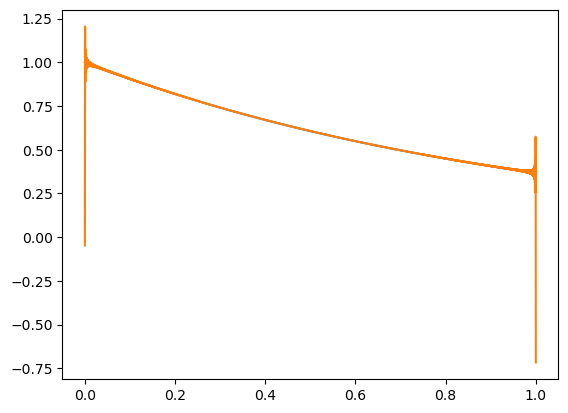

In [75]:
T = 1
Nfreq = 1000
Ntau = 20000
Momega = T*np.pi*(2*np.arange(Nfreq)+1)
tau, dtau = np.linspace(0,1/T,Ntau,endpoint=False,retstep=True)
tau = tau + dtau

G = np.exp(-tau)
GF = Matsubara_Fourier(G,tau,Momega)
plt.plot(tau, G, tau, Inv_Matsubara_Fourier_div(GF,T,tau,Momega))
plt.show()

In [65]:
A = np.ones((5,4))
B = np.ones(5)*3
print(B*A)

ValueError: operands could not be broadcast together with shapes (5,) (5,4) 